In [1]:
import torch
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import argparser
from models import *


/home/vllab/anaconda3/envs/swin-mil/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

  # 请替换为你的模型类或模块

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
parser = argparser.get_argparser()
opts = parser
opts.dataset = 'LUAD-HistoSeg'
opts.visualize = 0
opts.overlap = 1
opts.crop_size = 224
opts.output_stride = [4, 2, 2, 1]
opts.step = 0
opts.backbone = 'mit_b4'
opts = argparser.modify_command_options(opts)

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
# 创建模型实例
model = Swin_MIL(opts, 4)
# 加载已保存的模型参数
model.load_state_dict(torch.load('/home/vllab/Desktop/semantic-segmentation/Swin_MIL/work/test/s0_best_model.pth'))
# 将模型设置为评估模式
model.eval()


Swin_MIL(
  (backbone): mit_b4(
    (patch_embed1): OverlapPatchEmbed(
      (proj): Conv2d(3, 64, kernel_size=(7, 7), stride=(4, 4), padding=(3, 3))
      (norm): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed2): OverlapPatchEmbed(
      (proj): Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed3): OverlapPatchEmbed(
      (proj): Conv2d(128, 320, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (norm): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
    )
    (patch_embed4): OverlapPatchEmbed(
      (proj): Conv2d(320, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (block1): ModuleList(
      (0): Block(
        (norm1): LayerNorm((64,), eps=1e-06, elementwise_affine=True)
        (attn): Attention(
          (q): Linear(in_features=64, out_features=6

In [3]:
luad_test_img_root = '/home/vllab/Desktop/semantic-segmentation/Swin_MIL/data/LUAD-HistoSeg/test/img'
luad_test_gt_root = '/home/vllab/Desktop/semantic-segmentation/Swin_MIL/data/LUAD-HistoSeg/test/mask'
bcss_test_img_root = '/home/vllab/Desktop/semantic-segmentation/Swin_MIL/data/BCSS-WSSS/test/img'
bcss_test_gt_root = '/home/vllab/Desktop/semantic-segmentation/Swin_MIL/data/BCSS-WSSS/test/mask'

# image_path = f'{bcss_test_img_root}/387709-10004-55944.png'
# image = Image.open(image_path).convert('RGB')

# luad_test_img_root = '/home/vllab/Desktop/semantic-segmentation/Swin_MIL/data/LUAD-HistoSeg/test/img'
image_paths = [
                f'{bcss_test_img_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+0.png', 
                f'{bcss_test_img_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+5.png', 
                f'{bcss_test_img_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+7.png', 
                f'{bcss_test_img_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+129.png', 
                f'{bcss_test_img_root}/TCGA-D8-A27H-DX1_xmin8738_ymin8063_MPP-0.2500+7.png',
              ]

gt_paths = [
                f'{bcss_test_gt_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+0.png', 
                f'{bcss_test_gt_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+5.png', 
                f'{bcss_test_gt_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+7.png', 
                f'{bcss_test_gt_root}/TCGA-D8-A27F-DX1_xmin98787_ymin6725_MPP-0.2500+129.png', 
                f'{bcss_test_gt_root}/TCGA-D8-A27H-DX1_xmin8738_ymin8063_MPP-0.2500+7.png',
              ]



In [4]:
transform = transforms.Compose([  # 调整图像尺寸
    transforms.ToTensor(),
])





In [144]:
model = model.to(device)
input_image = input_image.to(device)
with torch.no_grad():
    side1, side2, side3, fusion, attns, d3, output = model(input_image)


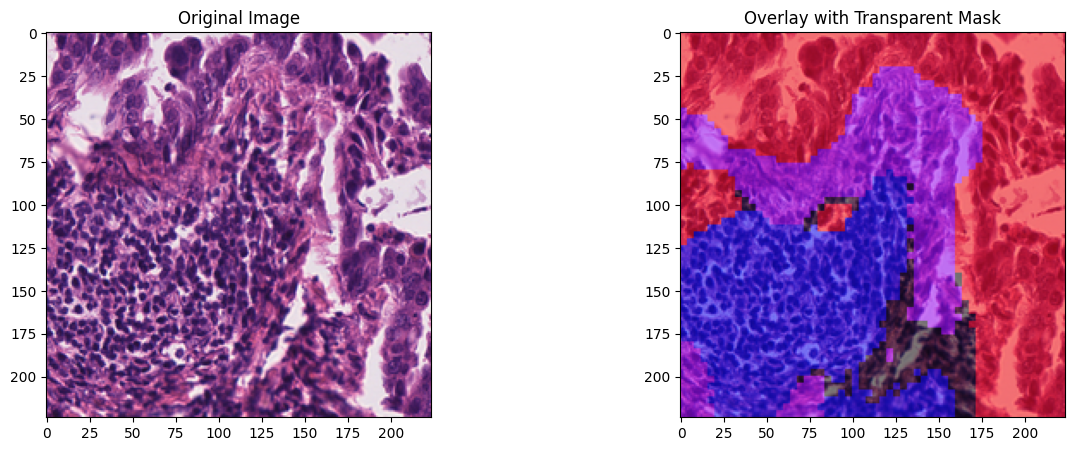

In [145]:
# 假设输出是概率图，可以使用阈值来生成二进制掩码
from matplotlib.colors import ListedColormap
class_probabilities = torch.sigmoid(output)
threshold = 0.5
binary_mask = (class_probabilities[0].cpu() >  threshold).squeeze().numpy()

# 创建一个包含四个类别的RGB图像
merged_mask = np.zeros((224, 224, 3), dtype=np.uint8)

# 为每个类别分配不同的颜色
# colors = [(205,51,51), (0,255,0), (65,105,225), (255,165,0)] #luad colors
colors = [(255, 0, 0), (0,255,0), (0,0,255), (153, 0, 255)] # bcss colors

num_classes = 4
for i in range(num_classes):
    resized_binary_mask = np.array(Image.fromarray(binary_mask[i]).resize((224, 224)))
    merged_mask[resized_binary_mask == 1] = colors[i]

image_np = np.transpose(input_image.cpu().squeeze().numpy(), (1, 2, 0))
# 可视化原始图像和第一个类别的预测掩码

plt.figure(figsize=(15, 5))

plt.subplot(1, 2, 1)
plt.imshow(image_np)
plt.title('Original Image')


plt.subplot(1, 2, 2)
plt.imshow(image_np)
plt.imshow(merged_mask, alpha=0.5)
plt.title('Overlay with Transparent Mask')

plt.show()


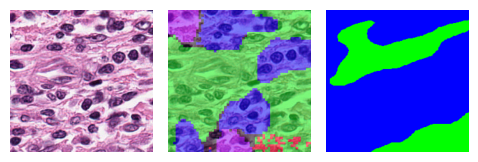

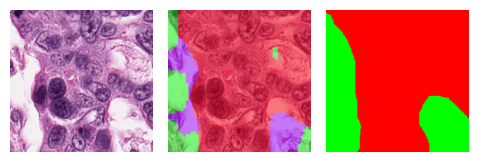

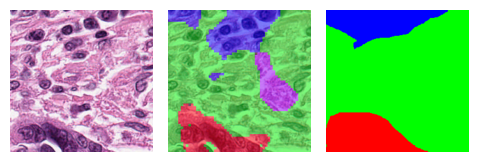

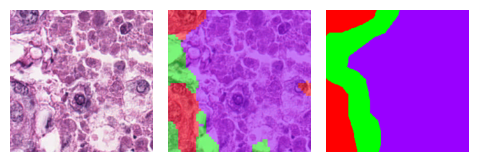

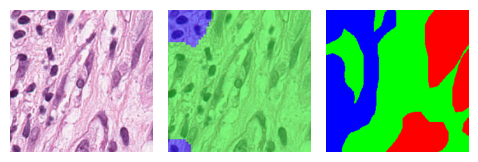

In [5]:
from matplotlib.colors import ListedColormap

for image_path, gt_path in zip(image_paths, gt_paths):
    image = Image.open(image_path).convert('RGB')
    gt = Image.open(gt_path).convert('RGB')
    input_image = transform(image).unsqueeze(0) 
    input_gt = transform(gt).unsqueeze(0)    # 添加批次维度

    model = model.to(device)
    input_image = input_image.to(device)
    with torch.no_grad():
        side1, side2, side3, fusion, attns, d3, output = model(input_image)

    
    class_probabilities = torch.sigmoid(output)
    threshold = 0.5
    binary_mask = (class_probabilities[0].cpu() >= threshold).squeeze().numpy()
    
    # 创建一个包含四个类别的RGB图像
    merged_mask = np.zeros((224, 224, 3), dtype=np.uint8)
    
    # 为每个类别分配不同的颜色
    # colors = [(205,51,51), (0,255,0), (65,105,225), (255,165,0)]  # 分别为红、绿、蓝和紫色
    colors = [(255, 0, 0), (0,255,0), (0,0,255), (153, 0, 255)] #bcss
    num_classes = 4
    all_masks = [input_image.cpu().squeeze().numpy()]
    
    for i in range(num_classes):
        resized_binary_mask = np.array(Image.fromarray(binary_mask[i]).resize((224, 224)))
        merged_mask[resized_binary_mask == 1] = colors[i]
        all_masks.append(merged_mask)
    
    image_np = np.transpose(input_image.cpu().squeeze().numpy(), (1, 2, 0))
    gt_np = np.transpose(input_gt.cpu().squeeze().numpy(), (1, 2, 0))
    # 可视化原始图像和第一个类别的预测掩码
    plt.figure(figsize=(10, 5))
    
    for i, mask in enumerate(all_masks, 1):
        plt.subplot(1, 5, i)
        plt.axis('off')
        if i == 1:
            plt.imshow(np.transpose(mask, (1, 2, 0)))  # 对于原始图像，需要转置通道
        else:
            plt.imshow(image_np)
            plt.imshow(mask, alpha=0.5)
            plt.subplot(1, 5, 3)
            plt.imshow(gt_np)
            plt.axis('off')
            break
    plt.subplots_adjust(wspace=0.113, hspace=0)  # 设置子图之间的间距为0
    plt.show()

    

In [1]:
import os
dataset = 'LUAD-HistoSeg'
root = f'data/{dataset}/training'
data = sorted(os.listdir(root)) # name
        
if dataset == 'LUAD-HistoSeg':
    label = [file[:-4].split(']')[0].split('[')[-1].split(' ') for file in data]
elif dataset == 'BCSS-WSSS':
    label = [[x for x in file[:-4].split(']')[0].split('[')[-1]] for file in data]
else:
    raise NotImplementedError
cls1 = 0
cls2 = 0
cls3 = 0
cls4 = 0
for lbl in label:
    # print(lbl)
    if lbl[0]=='1' and lbl[1]=='0' and lbl[2]=='0' and lbl[3]=='0':
        cls1 += 1
    elif lbl[0]=='0' and lbl[1]=='1' and lbl[2]=='0' and lbl[3]=='0':
        cls2 += 1
    elif lbl[0]=='0' and lbl[1]=='0' and lbl[2]=='1' and lbl[3]=='0':
        cls3 += 1
    elif lbl[0]=='0' and lbl[1]=='0' and lbl[2]=='0' and lbl[3]=='1':
        cls4 += 1

print(len(label))
print('Only cls1:',cls1)
print('Only cls2:',cls2)
print('Only cls3:',cls3)
print('Only cls4:',cls4)
print('total:', cls1+cls2+cls3+cls4)


16678
Only cls1: 1574
Only cls2: 787
Only cls3: 42
Only cls4: 2192
total: 4595


In [2]:
from pathlib import Path
import numpy as np
from torch.utils.data import Dataset as BaseDataset
import albumentations as albu
import torch

import copy
import random
import time
from functools import wraps
from PIL import Image
import matplotlib.pyplot as plt
import cv2
from skimage import morphology
from tqdm import tqdm

/home/vllab/anaconda3/envs/swin-mil/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
# LUAD-HistoSeg
palette = [0]*15                    
palette[0:3] = [205,51,51]          # Tumor epithelial (TE)
palette[3:6] = [0,255,0]            # Necrosis (NEC)
palette[6:9] = [65,105,225]         # Lymphocyte (LYM)
palette[9:12] = [255,165,0]         # Tumor-associated stroma (TAS)
palette[12:15] = [255, 255, 255]    # White background or exclude


# BCSS-WSSS
palette = [0]*15
palette[0:3] = [255, 0, 0]          # Tumor (TUM)
palette[3:6] = [0,255,0]            # Stroma (STR)
palette[6:9] = [0,0,255]            # Lymphocytic infiltrate (LYM)
palette[9:12] = [153, 0, 255]       # Necrosis (NEC)
palette[12:15] = [255, 255, 255]    # White background or exclude

In [3]:
def show_mask(image):
    palette = [0]*15                    
    palette[0:3] = [205,51,51]          # Tumor epithelial (TE)
    palette[3:6] = [0,255,0]            # Necrosis (NEC)
    palette[6:9] = [65,105,225]         # Lymphocyte (LYM)
    palette[9:12] = [255,165,0]         # Tumor-associated stroma (TAS)
    palette[12:15] = [255, 255, 255]    # White background or exclude
    image = Image.fromarray(np.uint8(image), mode='P')
    image.putpalette(palette)
    plt.imshow(image)
    plt.show()
    plt.close()
    
def show_background(image):
    plt.imshow(image, vmin=0, vmax=127, cmap='gray')
    plt.show()
    plt.close()

def show_image(image):
    if isinstance(image, torch.Tensor):
        image = rearrange(image, 'c h w -> h w c')
    plt.imshow(image)
    plt.show()
    plt.close()

def create_data(train_data):
    print(train_data)
    tumor_set, stroma_set, normal_set = set(), set(), set()
    for path in Path(train_data).glob('*.png'):
        if utils.is_tumor(path): tumor_set.add(str(path))
        if utils.is_stroma(path): stroma_set.add(str(path))
        if utils.is_normal(path): normal_set.add(str(path))

    tumor_images = list(tumor_set - stroma_set - normal_set)
    stroma_images = list(stroma_set - tumor_set - normal_set)
    normal_images = list(normal_set - tumor_set - stroma_set)

    return tumor_images, stroma_images, normal_images

In [4]:

def get_background(region):
    gray = cv2.cvtColor(region, cv2.COLOR_RGB2GRAY)
    ret, binary = cv2.threshold(gray, 200, 255, cv2.THRESH_BINARY)
    binary = np.uint8(binary)    
    dst = morphology.remove_small_objects(binary==255,min_size=50,connectivity=1)
    mask = np.array(dst, dtype=np.uint8)
    mask = mask * 255
    return mask

In [5]:
def get_patch_label(file):
    # [a: Tumor epithelial (TE), b: Necrosis (NEC), c: Lymphocyte (LYM), d: Tumor-associated stroma (TAS)] LUAD
    # Tumor (TUM), Stroma (STR), Lymphocytic infiltrate (LYM) and Necrosis (NEC) BCSS
    if isinstance(file, Path):
        file = str(file)
    fname = file[:-4]
    label_str = fname.split(']')[0].split('[')[-1]
    # print(label_str[0])
    label = [int(label_str[0]),int(label_str[2]),int(label_str[4]),int(label_str[6])]
    # label = [int(label_str[0]),int(label_str[1]),int(label_str[2]),int(label_str[3])]
    return label

In [6]:
def timeit(fn):
    """decorator for timing functions"""
    @wraps(fn)
    def measure_time(*args, **kwargs):
        t1 = time.time()
        result = fn(*args, **kwargs)
        t2 = time.time()
        logging.info(f"@timefn: {fn.__name__} took {t2 - t1: .5f} s")
        return result
    return measure_time

def visualize(save=None, **images):
    """PLot images in one row."""
    fontsize=14
    def axarr_show(axarr, image, name):
        if isinstance(image, torch.Tensor):
            if image.ndim == 3: image = image.permute(1, 2, 0)
            if image.is_cuda: image = image.detach().cpu().numpy()
        if name == 'mask': 
            palette = [0]*15                    
            palette[0:3] = [205,51,51]          # Tumor epithelial (TE)
            palette[3:6] = [0,255,0]            # Necrosis (NEC)
            palette[6:9] = [65,105,225]         # Lymphocyte (LYM)
            palette[9:12] = [255,165,0]         # Tumor-associated stroma (TAS)
            palette[12:15] = [255, 255, 255]    # White background or exclude
            image = Image.fromarray(np.uint8(image), mode='P')
            image.putpalette(palette)
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
        elif 'background' in name:
            palette = [255, 255, 255, 0, 0, 0]
            image = Image.fromarray(np.uint8(image), mode='P')
            image.putpalette(palette)
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
        else:
            axarr.imshow(image)
            axarr.set_title(name, fontsize=fontsize)
    n = len(images)
    fig, axarr = plt.subplots(nrows=1, ncols=n, figsize=(8, 8))
    if n == 1:
        name, image = list(images.items())[0]
        axarr_show(axarr, image, name)
        axarr.set_yticks([])
        axarr.set_xticks([])
    else:
        for i, (name, image) in enumerate(images.items()):
            axarr_show(axarr[i], image, name)
            
        for ax in axarr.ravel():
            ax.set_yticks([])
            ax.set_xticks([])
    plt.tight_layout()
    if save is not None:
        plt.savefig(save)
    else:
        plt.show()
    plt.close()

In [21]:
if True: # Set to True for first time runing the script
    train_dir = Path("./data/LUAD-HistoSeg/training")
    train_image_list = sorted(list(train_dir.glob('*.png')))

    background_save_dir = Path("./data/LUAD-HistoSeg/training/background-mask")
    background_save_dir.mkdir(exist_ok=True, parents=True)
    for train_image in tqdm(train_image_list):
        train_image_data = np.array(Image.open(str(train_image)))
        background_data = get_background(train_image_data)
        background_data[background_data > 0] = 1

        palette = [0, 0, 0, 255, 255, 255]
        background_mask = Image.fromarray(np.uint8(background_data), mode='P')
        background_mask.putpalette(palette)

        background_mask.save(str(background_save_dir / train_image.name))

        # blended = np.array(train_image_data)
        # blended[background_data > 0] = [0, 0, 0]
        
        # visualize(image=train_image_data, background=background_data, blended=blended, save=str(Path('data/temp_train_background') / train_image.name))

100%|██████████████████████████████| 16678/16678 [00:32<00:00, 520.22it/s]


In [22]:
assert len(os.listdir('./data/LUAD-HistoSeg/training/background-mask')) == len(os.listdir('./data/LUAD-HistoSeg/training/')) - 1

In [23]:
train_image_dir = Path('data/LUAD-HistoSeg/training/')
train_image_list = sorted(list(train_image_dir.glob('*.png')))
len(train_image_list)

16678

In [24]:
only_te_num = 0
only_nec_num = 0
only_lym_num = 0
only_tas_num = 0
single_type_num = 0

only_te_list = []
only_nec_list = []
only_lym_list = []
only_tas_list = []

for train_image in train_image_list:
    big_label = get_patch_label(train_image)
    if np.sum(big_label) == 1:
        single_type_num += 1
        if big_label[0] == 1:
            only_te_num += 1
            only_te_list.append(train_image)
        elif big_label[1] == 1:
            only_nec_num += 1
            only_nec_list.append(train_image)
        elif big_label[2] == 1:
            only_lym_num += 1
            only_lym_list.append(train_image)
        elif big_label[3] == 1:
            only_tas_num += 1
            only_tas_list.append(train_image)
            
assert single_type_num == only_te_num + only_nec_num + only_lym_num + only_tas_num
assert len(only_te_list) == only_te_num
assert len(only_nec_list) == only_nec_num
assert len(only_lym_list) == only_lym_num
assert len(only_tas_list) == only_tas_num

In [25]:
print(only_te_num, only_nec_num, only_lym_num, only_tas_num)
print(single_type_num)

1574 787 42 2192
4595


In [37]:
class CropAndConcatDataset(BaseDataset):    
    def __init__(self, train_dir, patch_num, patch_size, size=None):
       
        # self.args = args
        self.train_dir = train_dir
        self.train_images = list(Path(self.train_dir).glob('*.png'))
        self.te, self.nec, self.lym, self.tas = only_te_list, only_nec_list, only_lym_list, only_tas_list #luad
        # self.tum, self.str, self.lym, self.nec = only_tum_list, only_str_list, only_lym_list, only_nec_list #bcss
        self.single_type_images = self.te + self.nec + self.lym + self.tas

        self.patch_num = patch_num
        self.patch_size = patch_size

        self.total_len = len(self.single_type_images) if size is None else size

        self.crop_fn = albu.Compose([
            albu.PadIfNeeded(min_height=self.patch_size, min_width=self.patch_size),
            albu.RandomCrop(width=self.patch_size, height=self.patch_size)
        ])
        
        self.transform = albu.Compose([
            albu.Flip(),
            albu.RandomRotate90(),
        ])
    
    def __getitem__(self, i):
        np.random.seed(2022 + 2022 * i)
        random.seed(2022 + 2022 * i)
        H = W = self.patch_num * self.patch_size
        # image = np.zeros((H, W, 3), dtype=np.uint8)
        # mask = np.zeros((H, W), dtype=np.uint8)

        # h, w = int(H * (random.random()*0.6+0.2)), int(W * (random.random()*0.6+0.2))
        # h += h % 2
        # w += w % 2
        
        while True:
            try:
                (image_1, mask_1), (image_2, mask_2), (image_3, mask_3), (image_4, mask_4) = [self.create_one_image() for _ in range(4)] # [H, W, C]
                # print(image_1.shape)
                # print(image_2.shape)
                # print(image_3.shape)
                # print(image_4.shape)
                
                image, mask = self.create_mosaic(H, W, image_1, mask_1, image_2, mask_2, image_3, mask_3, image_4, mask_4)
                break            
            except AssertionError as e:
                print(e)

        # image[:h, :w, :] = image_1
        # image[:h, w:W, :] = image_2
        # image[h:H, :w, :] = image_3
        # image[h:H, w:W, :] = image_4
    
        # mask[:h, :w] = mask_1
        # mask[:h, w:W] = mask_2
        # mask[h:H, :w] = mask_3
        # mask[h:H, w:W] = mask_4

        
        # return image_1, mask_1
        return image, mask

    def create_one_image(self):      
        H = W = self.patch_num * self.patch_size
        image = np.zeros((H, W, 3), dtype=np.uint8)
        mask = np.zeros((H, W), dtype=np.uint8)



        for i in range(self.patch_num):
            for j in range(self.patch_num):

                tile_name = np.random.choice(self.single_type_images)
                label = get_patch_label(tile_name)
                assert sum(label) == 1
                tile = np.asarray(Image.open(tile_name))
                label = label.index(1)
                tile_mask = np.full((tile.shape[0], tile.shape[1]), label)
                background_mask = np.array(Image.open(Path(self.train_dir) / 'background-mask' / Path(tile_name).name))
                tile_mask[background_mask > 0] = 4

                sample = self.crop_fn(image=tile, mask=tile_mask)
                tile = sample['image']
                tile_mask = sample['mask']
                
                image[i*self.patch_size: (i+1)*self.patch_size, j*self.patch_size: (j+1)*self.patch_size] = tile
                mask[i*self.patch_size: (i+1)*self.patch_size, j*self.patch_size: (j+1)*self.patch_size] = tile_mask
        
        return image, mask
    
    def create_mosaic(self, H, W, image_1, mask_1, image_2, mask_2, image_3, mask_3, image_4, mask_4):
        def get_transforms(height, width, p=0.5):
            _transform = [
                # albu.Flip(p=p),
                albu.ShiftScaleRotate(shift_limit=0.0625, scale_limit=0.2, rotate_limit=45, p=p),
                albu.RandomCrop(height, width),
            ]
            return albu.Compose(_transform)
        
        image = np.zeros((H, W, 3), dtype=np.uint8)
        mask = np.zeros((H, W), dtype=np.uint8)

        h, w = int(H * (random.random()*0.6+0.2)), int(W * (random.random()*0.6+0.2))
        h += h % 2
        w += w % 2

        transform_1 = get_transforms(height=h, width=w, p=0.8)
        sample = transform_1(image=image_1, mask=mask_1)
        image_1, mask_1 = sample['image'], sample['mask']

        transform_2 = get_transforms(height=h, width=W-w, p=0.8)
        sample = transform_2(image=image_2, mask=mask_2)
        image_2, mask_2 = sample['image'], sample['mask']

        transform_3 = get_transforms(height=H-h, width=w, p=0.8)
        sample = transform_3(image=image_3, mask=mask_3)
        image_3, mask_3 = sample['image'], sample['mask']

        transform_4 = get_transforms(height=H-h, width=W-w, p=0.8)
        sample = transform_4(image=image_4, mask=mask_4)
        image_4, mask_4 = sample['image'], sample['mask']
        
        image[:h, :w, :] = image_1
        image[:h, w:W, :] = image_2
        image[h:H, :w, :] = image_3
        image[h:H, w:W, :] = image_4
    
        mask[:h, :w] = mask_1
        mask[:h, w:W] = mask_2
        mask[h:H, :w] = mask_3
        mask[h:H, w:W] = mask_4
        
        return image, mask

    def __len__(self):
        return self.total_len

In [40]:
# from argparse import Namespace
from torch.utils.data import DataLoader
# args = Namespace()
train_dir = "./data/LUAD-HistoSeg/training"

# set to 2 and 112 for better performance
patch_num = 2
patch_size = 112
dataset = CropAndConcatDataset(train_dir, patch_num=patch_num, patch_size=patch_size, size=10000)
dataloader = DataLoader(dataset, batch_size=16, num_workers=8)

len(dataset)

10000

0
(224, 224, 3) (224, 224)


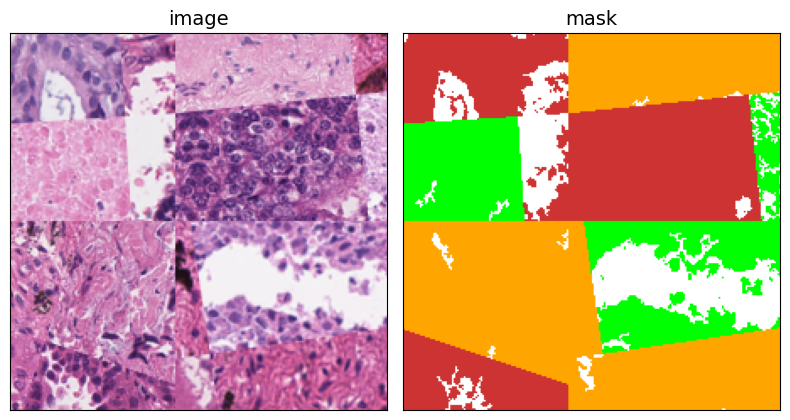

1
(224, 224, 3) (224, 224)


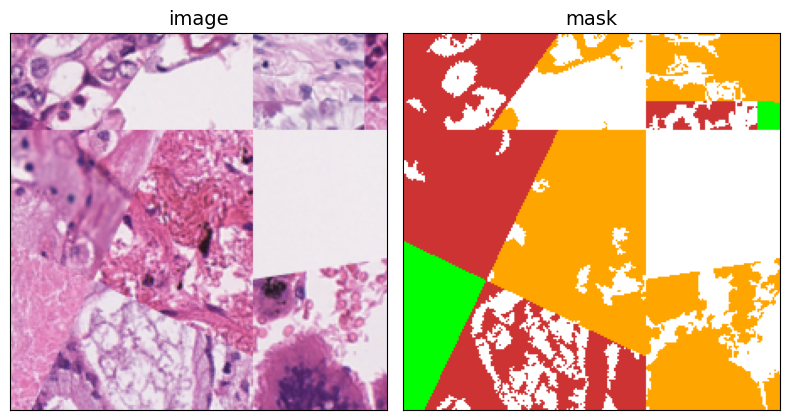

2
(224, 224, 3) (224, 224)


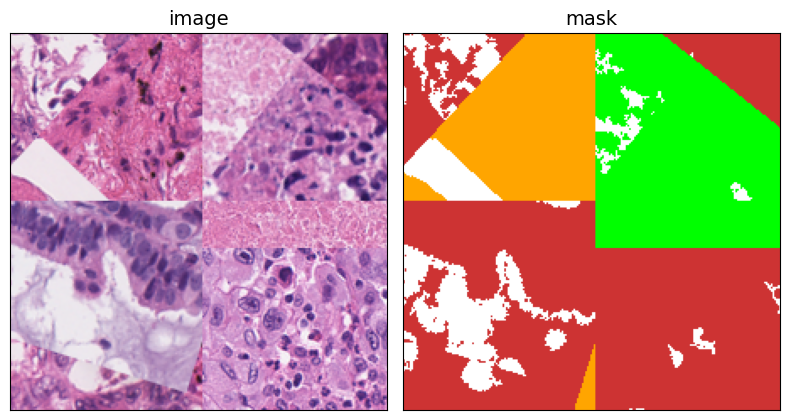

3
(224, 224, 3) (224, 224)


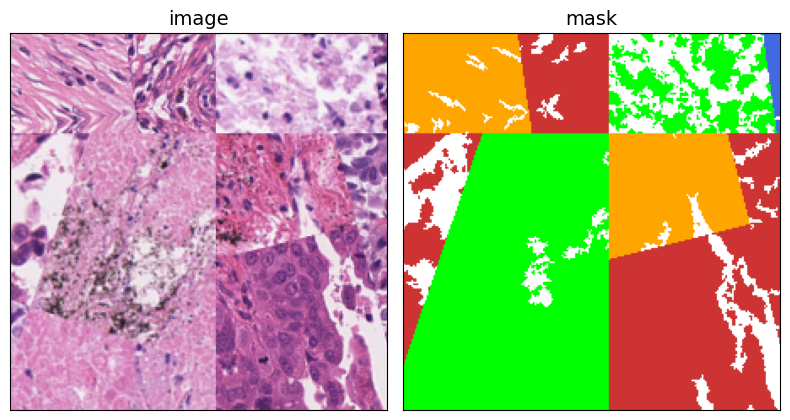

In [41]:
ct = 0
for i, (image, mask) in enumerate(dataset):
    if ct < 4:
        print(i)
        print(image.shape, mask.shape)
        visualize(image=image, mask=mask)
        ct += 1
    else:
        break

In [42]:
mosaic_data = Path(f"./data/LUAD-HistoSeg/onelabel_{patch_num}_{patch_size}")
(mosaic_data / 'img').mkdir(parents=True, exist_ok=True)
(mosaic_data / 'mask').mkdir(parents=True, exist_ok=True)
def func(indexes):
    for i in indexes:
        image, mask = dataset[i]
        image = Image.fromarray(image)
        palette = [0]*15
        palette[0:3] = [205,51,51]          # Tumor epithelial (TE)
        palette[3:6] = [0,255,0]            # Necrosis (NEC)
        palette[6:9] = [65,105,225]         # Lymphocyte (LYM)
        palette[9:12] = [255,165,0]         # Tumor-associated stroma (TAS)
        palette[12:15] = [255, 255, 255]    # White background or exclude
        # palette[0:3] = [255, 0, 0]          # Tumor (TUM)
        # palette[3:6] = [0,255,0]            # Stroma (STR)
        # palette[6:9] = [0,0,255]            # Lymphocytic infiltrate (LYM)
        # palette[9:12] = [153, 0, 255]       # Necrosis (NEC)
        # palette[12:15] = [255, 255, 255]    # White background or exclude
        mask = Image.fromarray(np.uint8(mask), mode='P')
        mask.putpalette(palette)
        image.save(mosaic_data / 'img' / f'{patch_num}_{patch_size}_{i}.png')
        mask.save(mosaic_data / 'mask' / f'{patch_num}_{patch_size}_{i}.png')
def print_error(value):
    print("error: ", value)

In [43]:
from multiprocessing import Process
process_list = []
num_processors = 8
for i in range(num_processors): 
    p = Process(target=func,args=(range(i, len(dataset), num_processors),)) 
    p.start()
    process_list.append(p)

for i in process_list:
    p.join()